In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette('husl')
from sklearn.metrics import ConfusionMatrixDisplay

from FakeNews.Data import Data
from FakeNews.Cleaner import Cleaner
from FakeNews.Predictor import Predictor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split as tts

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Comparing Unsupervised and Supervised Algorithms for Fake News Detection
## Binary Document Classification with K-Means and Support Vector Machines

Author: Jonathan Chernoch
Class: Unsupervised Algorithms in Machine Learning
Instructor: Geena Kim
Github Repo: https://github.com/chernobylx/Fake-News-Identification

# Abstract


In this notebook I trained four pipelines to perform binary document classification on ~40,000 articles from the ISOT Fake News Dataset. I used
Term-Frequency Inverse-Document-Frequency to vectorize the titles and bodies of the articles. Dimensionality reduction was then applied using  either
Principal Component Analysis or Non-Negative Matrix Factorization. Finally, predictions were made using either a Support Vector Classifier or with
K-Means(K=2) Clustering. The 4 pipelines were tuned using Grid Search Cross Validation. Cross Validation accuracy was used to select the best parameters.
The PCA-SVC pipeline achieved a test set accuracy of 99.6%. The NMF-SVC pipeline achieved a test set accuracy of 97.1%. The PCA-KMeans pipeline achieved a
test set accuracy of 96.4%. The NMF-KMeans pipeline achieved a test set accuracy of 96.1%. The best overall pipeline was the PCA-SVC pipeline with an accuracy of 99.6%


# Introduction

Since its inception the internet has been rife with misinformation[1]. In recent years social media has accelerated the spread of misinformation, disinformation and malinformation. Misinformation is false or misleading information that is spread unintentiaonally. Disinformation is false or misleading information that is spread intentiaonally with the intent to deceive others. Malinformation is disinformation spread with the explicit intent of causing harm to others. Some of the most harmful forms of false information spread on social media are news stories, frequently referred to as "Fake News". In particular the confirmation bias of users drives content delivery algorithms to serve users information that aligns with their world view. When this world view becomes divorced from reality users often find themselves inside of digital filter bubbles that predominately contain misinformation and disinformation[2]. The predominant vectors for the spread of fake news are Facebook and X[3], however any platform where content is shared from between users is likely to facilitate the spread to some degree. One of the main ways that platforms can protect their users from harmful information is the deployment of machine learning models to flag and filter articles suspected of being disinformation. In recent years the machine learning community has taken an interest in this problem with many different models, mostly neural networks, being explored as viable options[3]. The goal of this notebook is to assess the performance and viability of Support Vector Machines and K-Means clustering as fake news detection models. Additionally, the efficacy of using Principal Component Analysis and Non-Negative Matrix Factorization applied to Term Frequency - Inverse Document Frequency vectors for preprocessing. The data set used to train and test the models is the ISOT Fake News Dataset[0] which consists of ~45,000 articles gathered from real sources and labeld as either real or fake by politifact.

# Data loading / Initial Exploration

In [6]:
data = Data()
data.load()
data.df.sample(5, random_state=27)

,title,text,subject,date,Real
41686,BLACK LIVES MATTER TERRORISTS Take To Social M...,There are no words for these selfish sub-human...,left-news,"Jul 15, 2016",False
18804,Russian hacker wanted by U.S. tells court he w...,MOSCOW (Reuters) - A Russian hacker arrested i...,worldnews,"September 28, 2017",True
7967,"Kansas, ACLU reach temporary agreement on vote...",(Reuters) - The Kansas Secretary of State and ...,politicsNews,"September 29, 2016",True
30472,WATCH: ’’Carpetbagger” Mitt Romney Takes Swipe...,The GOP presidential candidate who couldn t se...,politics,18-Feb-18,False
35606,AFTER GM’S TAXPAYER BAILOUT AND $10 BILLION IN...,Was the GM bailout REALLY about American jobs?...,politics,"Mar 31, 2016",False


In [7]:
data.df.shape
shape_str = f'The data frame has {data.df.shape[0]} rows and {data.df.shape[1]} columns'
print(shape_str)

The data frame has 44898 rows and 5 columns


In [8]:
print('The following columns are present in the data frame:')
print('\t'.join(data.df.columns))

The following columns are present in the data frame:
title	text	subject	date	Real


In [9]:
data.df.info()
print('The columns contain string objects except for Real which contains booleans')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Real     44898 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.4+ MB
The columns contain string objects except for Real which contains booleans


In [10]:
data.df.isna().sum()
print('There are no nan values in the data frame')

There are no nan values in the data frame


In [11]:
print(f'There are {data.df[data.df.duplicated()].shape[0]} rows with exact duplicates in the data frame')
data.df[data.df.duplicated()]

There are 209 rows with exact duplicates in the data frame


,title,text,subject,date,Real
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",True
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",True
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017",True
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017",True
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017",True
...,...,...,...,...,...
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",True
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",True
31359,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",False
32863,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",False


In [12]:
print(f'There are {data.df[(data.df.duplicated(subset = 'text') | data.df.duplicated(subset = 'title'))].shape[0]} rows with either duplicated text or duplicated titles')
data.df[(data.df.duplicated(subset = 'text') | data.df.duplicated(subset = 'title'))]

There are 6628 rows with either duplicated text or duplicated titles


,title,text,subject,date,Real
166,Factbox: What is in the U.S. Republicans' fina...,(Reuters) - Republicans in the U.S. Congress r...,politicsNews,"December 14, 2017",True
250,Aide tries to refocus U.S. tax debate after Tr...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"December 7, 2017",True
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017",True
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017",True
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017",True
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",False
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",False
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",False
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",False


In [13]:
print(f'There are {data.df[data.df.date.str.contains('http') | data.df.date.str.contains('MSNBC')].shape[0]} articles whose date is not formatted correctly')
data.df[data.df.date.str.contains('http') | data.df.date.str.contains('MSNBC')]

There are 10 articles whose date is not formatted correctly


,title,text,subject,date,Real
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,False
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,False
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,False
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,False
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,False
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,False
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,False
40350,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,False
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,False
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,False


The articles are evenly balanced between real and fake articles


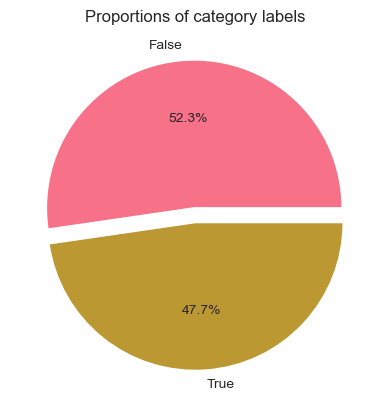

In [146]:
data.df.Real.value_counts().plot.pie(autopct = '%.1f%%', explode = [.05] * 2)
plt.ylabel('')
plt.title('Proportions of category labels')
print('The articles are evenly balanced between real and fake articles')

Text(0.5, 1.0, 'Histogram of Article\n Title Word Count')

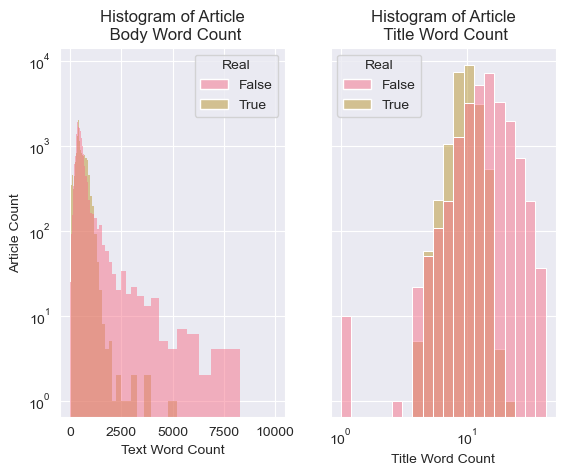

In [149]:
data.df['word_count_text'] = data.df.text.str.split().apply(len)
data.df['word_count_title'] = data.df.title.str.split().apply(len)
fig, axes = plt.subplots(1,2, sharey=True)
plt.loglog()
sns.histplot(data.df, x = 'word_count_text', ax=axes[0], hue = 'Real', bins = np.logspace(0, 4, 100))
sns.histplot(data.df, x = 'word_count_title', ax=axes[1], hue = 'Real', bins = 20)
axes[0].set_ylabel('Article Count')
axes[0].set_xlabel('Text Word Count')
axes[1].set_xlabel('Title Word Count')
axes[0].set_title('Histogram of Article\n Body Word Count')
axes[1].set_title('Histogram of Article\n Title Word Count')

In [16]:
print(f'There are {data.df[data.df.word_count_text < data.df.word_count_title].shape[0]} article stubs whose text word count is less than their title word count')
data.df[data.df.word_count_text < data.df.word_count_title]

There are 954 article stubs whose text word count is less than their title word count


,title,text,subject,date,Real,word_count_text,word_count_title
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",True,0,4
32340,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",False,0,15
32458,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",False,0,19
32534,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,Enjoy:,politics,"Apr 17, 2017",False,1,7
32607,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",False,0,13
...,...,...,...,...,...,...,...
43244,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",False,0,11
43274,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",False,0,12
43285,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...,Hillary Clinton s supporters were calling cert...,left-news,"Apr 12, 2015",False,31,39
43290,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015",False,0,14


# Cleaning and Preprocessing

In [17]:
cleaner = Cleaner()
cleaner.fit(data.X)
X_clean = pd.DataFrame(cleaner.transform(data.X), columns = data.X.columns)
y_clean = pd.DataFrame(cleaner.transform(data.y), columns = ['Real'])
cleaner.summary()

Cleaning...
Cleaning...
Data Successfully Cleaned


In [18]:
X_clean

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
38035,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016"
38036,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016"
38037,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016"
38038,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016"


In [19]:
y_clean

,Real
0,True
1,True
2,True
3,True
4,True
...,...
38035,False
38036,False
38037,False
38038,False


In [20]:
tfidfs = {}
tfidfs['text'] = TfidfVectorizer(max_features=10000, stop_words='english')
tfidfs['title'] = TfidfVectorizer(max_features=10000, stop_words='english')

vectors = {}
vectors['text'] = tfidfs['text'].fit_transform(X_clean.text)
vectors['title'] = tfidfs['title'].fit_transform(X_clean.title)

vector_dfs = {}
vector_dfs['text'] = pd.DataFrame(vectors['text'].toarray(),
                               columns = tfidfs['text'].get_feature_names_out())

vector_dfs['title'] = pd.DataFrame(vectors['title'].toarray(),
                               columns = tfidfs['title'].get_feature_names_out())

vector_dfs['text'] = pd.concat([y_clean, vector_dfs['text']], axis = 1)
vector_dfs['title'] = pd.concat([y_clean, vector_dfs['title']], axis = 1)

In [21]:
vector_dfs['title'].describe().T.sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
trump,38040.0,0.038037,0.056489,0.0,0.0,0.0,0.099839,0.391170
video,38040.0,0.021152,0.051745,0.0,0.0,0.0,0.000000,0.557732
says,38040.0,0.016644,0.054666,0.0,0.0,0.0,0.000000,0.635903
obama,38040.0,0.011827,0.047937,0.0,0.0,0.0,0.000000,0.524434
house,38040.0,0.010846,0.049794,0.0,0.0,0.0,0.000000,0.553169
...,...,...,...,...,...,...,...,...
knight,38040.0,0.000026,0.003623,0.0,0.0,0.0,0.000000,0.553568
blacklisted,38040.0,0.000026,0.002945,0.0,0.0,0.0,0.000000,0.382459
faisal,38040.0,0.000026,0.002898,0.0,0.0,0.0,0.000000,0.347077
mohammad,38040.0,0.000026,0.002898,0.0,0.0,0.0,0.000000,0.347077


In [22]:
pcas = {}
pcas['title'] = PCA(n_components=1000).fit(vectors['title'])
pcas['text'] = PCA(n_components=1000).fit(vectors['text'])

pcs = {}
pcs['title'] = pd.DataFrame(pcas['title'].transform(vectors['title']))
pcs['title'] = pd.concat([y_clean, pd.DataFrame(pcs['title'])], axis = 1)
pcs['text'] = pd.DataFrame(pcas['text'].transform(vectors['text']))
pcs['text'] = pd.concat([y_clean, pd.DataFrame(pcs['text'])], axis = 1)
pcs['title']




,Real,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,True,-0.018361,0.000437,-0.053331,-0.013553,-0.045662,-0.004774,0.031318,-0.032410,0.003896,...,-0.009538,0.003946,0.011925,0.007870,-0.000825,0.001718,-0.028518,0.018466,-0.000654,-0.016505
1,True,-0.031621,-0.027952,-0.032629,0.003294,-0.023186,-0.000826,-0.022184,0.007704,-0.005809,...,0.024676,0.004507,0.008288,0.014818,-0.028154,0.005564,0.021350,0.008616,-0.001204,0.012871
2,True,-0.015177,0.005821,-0.041189,-0.035449,-0.037074,0.017676,0.089279,-0.120845,0.047120,...,-0.006548,-0.012522,-0.002180,0.000942,-0.000102,0.022750,-0.018242,0.008761,-0.005226,0.016289
3,True,-0.051737,-0.009573,-0.009247,-0.031102,0.006577,0.074760,-0.060674,0.065460,0.233391,...,-0.024398,0.010183,0.043570,0.018143,-0.012142,-0.020709,-0.021223,0.000362,0.013546,0.024854
4,True,0.023553,0.008508,0.038696,-0.033756,-0.035396,0.003812,-0.017843,0.005312,-0.015837,...,-0.005569,-0.011615,-0.009549,-0.007324,-0.006527,-0.013706,-0.004789,0.007006,-0.014822,-0.011037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38035,False,-0.112990,0.482413,-0.136380,0.151002,0.033274,0.007296,-0.092968,0.019547,-0.048196,...,-0.000791,0.002615,0.000915,-0.000780,-0.004004,0.001925,-0.004487,0.002177,0.001103,0.000831
38036,False,-0.003022,-0.026642,-0.038856,0.008863,-0.012433,0.000680,-0.031635,-0.003165,-0.001360,...,-0.023450,-0.022687,0.010702,-0.008308,-0.037476,0.023587,-0.008786,0.010373,0.053742,0.002557
38037,False,-0.016172,-0.028050,-0.044116,0.001231,-0.023320,0.001647,-0.023182,0.000546,-0.008437,...,0.001509,0.006252,0.004476,-0.014967,-0.004452,0.002392,-0.003334,-0.008738,-0.000657,-0.014431
38038,False,-0.010831,-0.025746,-0.044099,0.000163,-0.023118,0.003443,-0.011097,0.000953,-0.013959,...,-0.001254,0.026870,0.016268,0.012242,-0.008341,-0.002536,-0.032334,0.039833,-0.007848,-0.024225


In [23]:
nmfs = {}
nmfs['title'] = {}
nmfs['text'] = {}
nmfs['title'][4] = NMF(n_components=4).fit(vectors['title'])
nmfs['text'][4] = NMF(n_components=4).fit(vectors['text'])
nmfs['title'][2] = NMF(n_components=2).fit(vectors['title'])
nmfs['text'][2] = NMF(n_components=2).fit(vectors['text'])

Hs = {}
Hs['title'] = {}
Hs['text'] = {}
Hs['title'][2] = pd.DataFrame(nmfs['title'][2].components_, columns = tfidfs['title'].get_feature_names_out())
Hs['text'][2]  = pd.DataFrame(nmfs['text'][2].components_, columns = tfidfs['text'].get_feature_names_out())
Hs['title'][4] = nmfs['title'][4].components_
Hs['text'][4]  = nmfs['text'][4].components_

Ws = {}
Ws['title'] = {}
Ws['text'] = {}
Ws['title'][2] = pd.DataFrame(nmfs['title'][2].transform(vectors['title'])).join(y_clean)
Ws['text'][2] = pd.DataFrame(nmfs['text'][2].transform((vectors['text']))).join(y_clean)
Ws['title'][4] = pd.DataFrame(nmfs['title'][4].transform(vectors['title'])).join(y_clean)
Ws['text'][4] = pd.DataFrame(nmfs['text'][4].transform((vectors['text']))).join(y_clean)

In [24]:
Ws['title']

{2:               0         1   Real
 0      0.004351  0.006329   True
 1      0.001019  0.006972   True
 2      0.007851  0.009513   True
 3      0.002067  0.019872   True
 4      0.018943  0.002613   True
 ...         ...       ...    ...
 38035  0.000000  0.088026  False
 38036  0.004931  0.000117  False
 38037  0.001151  0.000659  False
 38038  0.003947  0.001157  False
 38039  0.004004  0.001465  False
 
 [38040 rows x 3 columns],
 4:               0         1         2         3   Real
 0      0.003662  0.001660  0.009251  0.000000   True
 1      0.001011  0.004493  0.001100  0.004240   True
 2      0.006499  0.006573  0.008400  0.000000   True
 3      0.001063  0.020114  0.003173  0.001282   True
 4      0.017460  0.002199  0.000621  0.000597   True
 ...         ...       ...       ...       ...    ...
 38035  0.000000  0.000000  0.165848  0.000000  False
 38036  0.004513  0.000295  0.000000  0.000000  False
 38037  0.001032  0.000430  0.000263  0.000464  False
 38038  0.003547 

# EDA
## Term Frequency - Inverse Document Frequency

In [26]:
top_words = {}
df_title = vector_dfs['title'].groupby('Real').mean().T
df_text = vector_dfs['text'].groupby('Real').mean().T
top_words['title_real'] = df_title.sort_values(True, ascending = False).head(10).index
top_words['title_fake'] = df_title.sort_values(False, ascending = False).head(10).index
top_words['text_real'] = df_text.sort_values(True, ascending = False).head(10).index
top_words['text_fake'] = df_text.sort_values(False, ascending = False).head(10).index

In [27]:
pd.DataFrame(top_words)

,title_real,title_fake,text_real,text_fake
0,trump,video,said,trump
1,says,trump,trump,clinton
2,house,watch,reuters,people
3,russia,obama,president,just
4,north,hillary,state,obama
5,korea,just,house,president
6,senate,donald,government,hillary
7,china,gop,washington,like
8,white,president,republican,said
9,new,clinton,united,donald


In [30]:

df_title_comps = pd.DataFrame(pcas['title'].components_, columns = tfidfs['title'].get_feature_names_out()).T

df_text_comps = pd.DataFrame(pcas['text'].components_, columns = tfidfs['text'].get_feature_names_out()).T


In [31]:
print('Most significant words for the first principle component of the title data')
print(df_title_comps.sort_values(0).iloc[[0,1,2,3,4, -5,-4,-3,-2,-1], 0])


Most significant words for the first principle component of the title data
says      -0.381155
korea     -0.282713
north     -0.263500
house     -0.166909
china     -0.122936
donald     0.136595
hillary    0.138899
watch      0.147494
trump      0.372580
video      0.448620
Name: 0, dtype: float64


In [32]:
print('Most significant words for the second principle component of the title data')
print(df_title_comps.sort_values(1).iloc[[0,1,2,3,4, -5,-4,-3,-2,-1], 1])

Most significant words for the second principle component of the title data
north        -0.090928
korea        -0.090873
china        -0.052363
eu           -0.046545
brexit       -0.039486
republican    0.075016
tax           0.109906
trump         0.267971
white         0.555332
house         0.699233
Name: 1, dtype: float64


In [33]:
print('Most significant words for the first principle component of the text data')
print(df_text_comps.sort_values(0).iloc[[0,1,2,3,4, -5,-4,-3,-2,-1], 0])

Most significant words for the first principle component of the text data
korea        -0.096796
north        -0.091431
government   -0.077536
said         -0.077352
minister     -0.076258
republican    0.117018
campaign      0.122875
donald        0.133206
clinton       0.196988
trump         0.661239
Name: 0, dtype: float64


In [34]:
print('Most significant words for the second principle component of the text data')
print(df_text_comps.sort_values(1).iloc[[0,1,2,3,4, -5,-4,-3,-2,-1], 1])

Most significant words for the second principle component of the text data
police    -0.100339
people    -0.063391
black     -0.060646
gun       -0.050796
court     -0.050671
nuclear    0.192828
china      0.209469
north      0.322859
trump      0.333395
korea      0.373125
Name: 1, dtype: float64


Text(0.5, 1.0, 'Portion of Variance Explained by the First 1000 Principal Components')

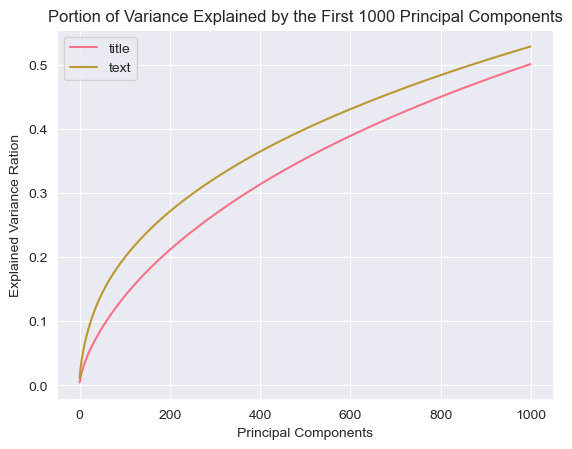

In [150]:
fig, ax = plt.subplots(1,1)
sns.lineplot(pcas['title'].explained_variance_ratio_.cumsum(), ax=ax, label = 'title')
sns.lineplot(pcas['text'].explained_variance_ratio_.cumsum(), ax=ax, label = 'text')
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance Ration')
ax.set_title('Portion of Variance Explained by the First 1000 Principal Components')

Text(0.5, 0.98, 'Pairplot of the First 4 Text Principal Components')

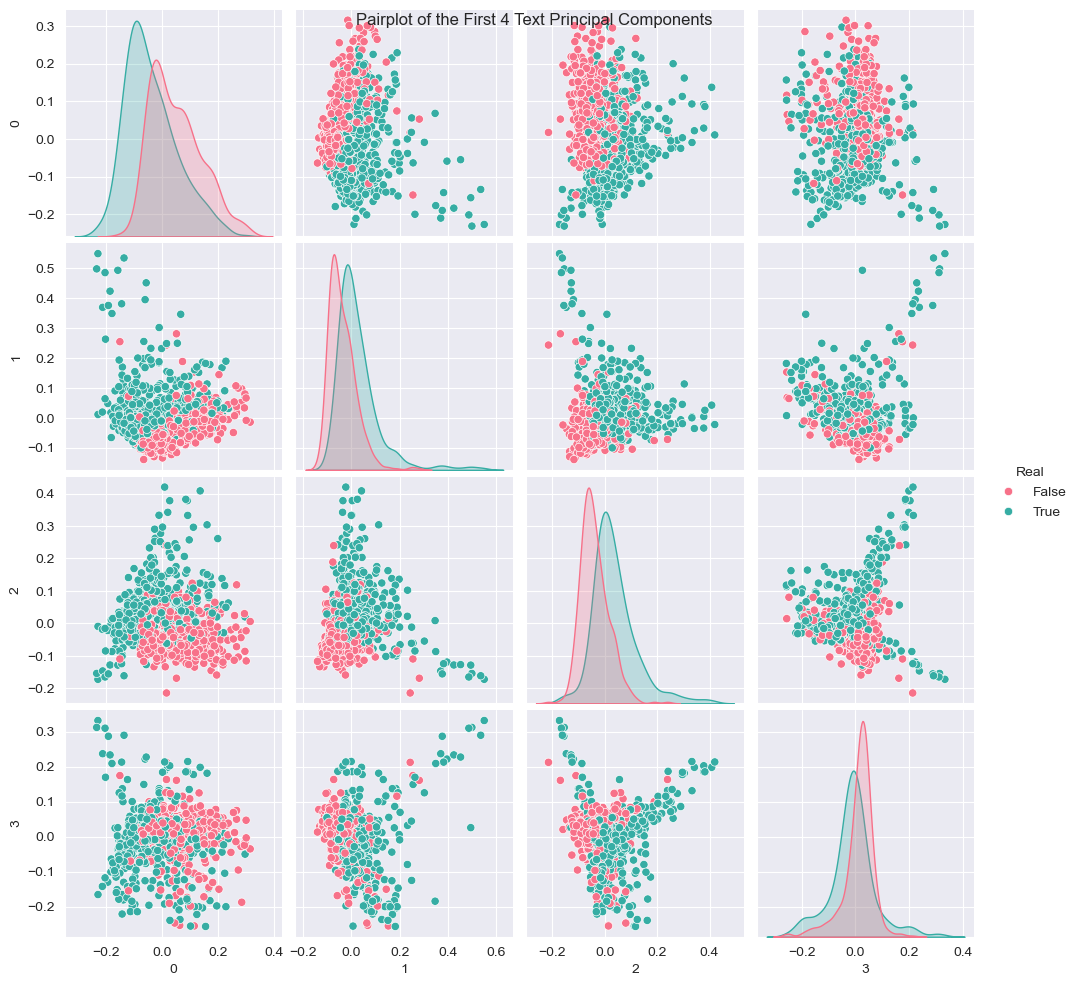

In [163]:
sns.pairplot(pcs['text'].sample(1000).loc[:,['Real',0,1,2,3]], hue = 'Real', palette = 'husl')
plt.suptitle('Pairplot of the First 4 Text Principal Components')

Text(0.5, 1.0, 'Pairplot of the First 4 Title Principal Components')

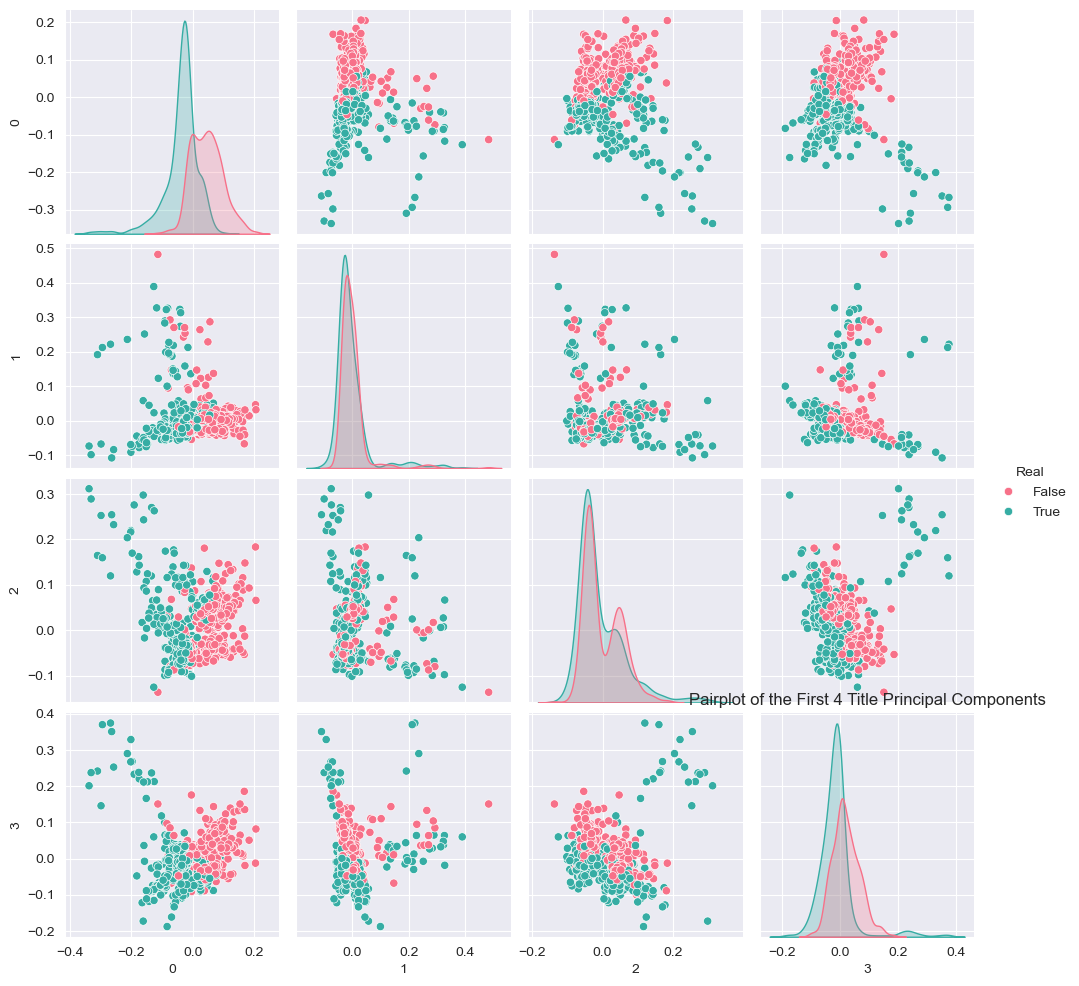

In [160]:
sns.pairplot(pcs['title'].sample(1000).loc[:,['Real',0,1,2,3]], hue = 'Real', palette = 'husl')
plt.suptitle('Pairplot of the First 4 Title Principal Components')

Text(0.5, 0.98, 'Pairplot of the first 2 Principal Components each for Text and Title ')

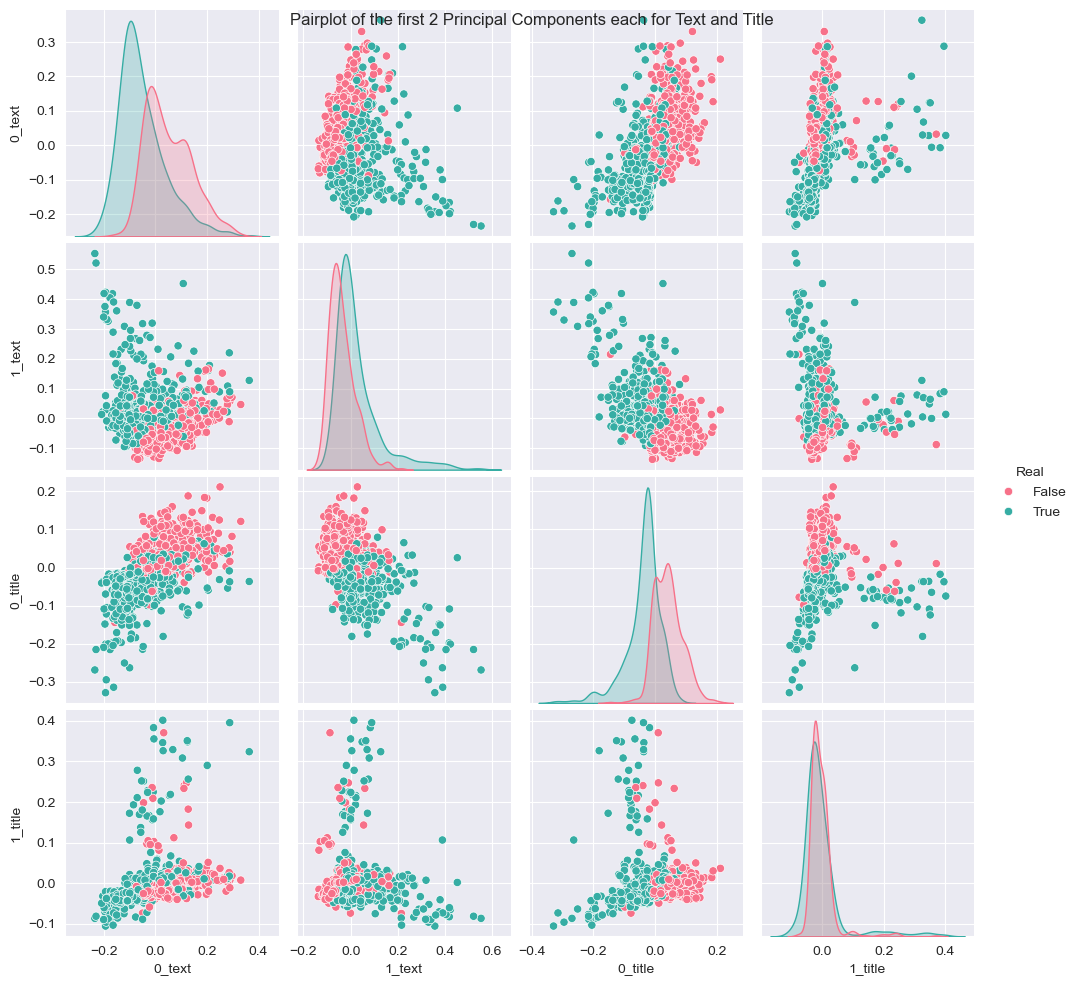

In [162]:
combined_pcs = pcs['text'].loc[:,['Real',0,1]].join(pcs['title'].loc[:,[0,1]], lsuffix='_text', rsuffix='_title')
sns.pairplot(combined_pcs.sample(1000), hue = 'Real', palette = 'husl')
plt.suptitle('Pairplot of the first 2 Principal Components each for Text and Title ')

Text(0.5, 0.98, 'Pairplot of Title Document Matrix(W) for NMF(n_components = 2)')

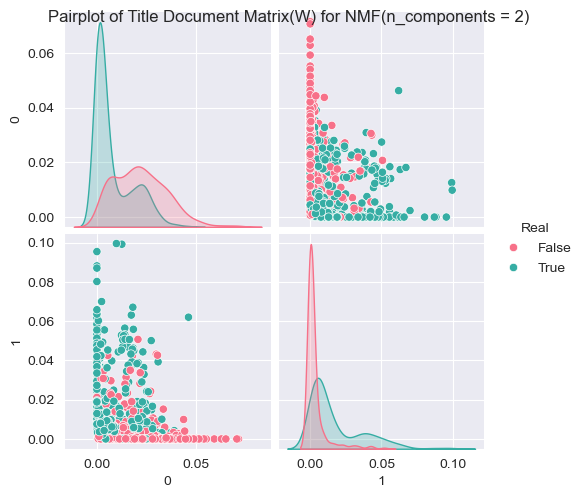

In [165]:
sns.pairplot(Ws['title'][2].sample(1000), hue = 'Real', palette = 'husl')
plt.suptitle('Pairplot of Title Document Matrix(W) for NMF(n_components = 2)')

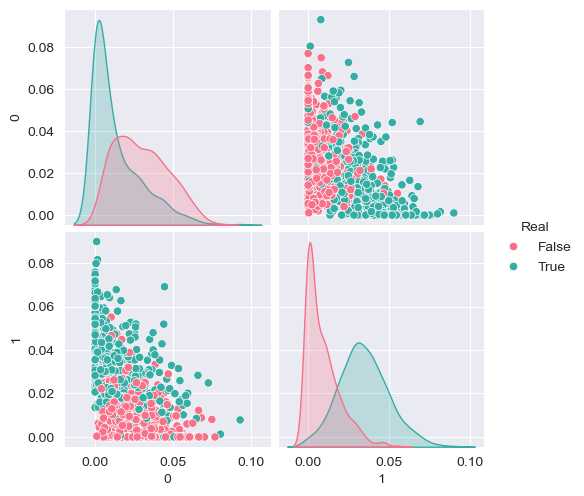

In [144]:
sns.pairplot(Ws['text'][2].sample(1000), hue = 'Real', palette = 'husl')
plt.suptitle('Pairplot of Text Document Matrix(W) for NMF(n_components = 2)')

In [167]:
print('Most important words from the NMF Title Feature Matrix(H) for Fake label')
Hs['title'][2].T.sort_values(0, ascending = False).head(10)

Most important words from the NMF Title Feature Matrix(H) for Fake label


,0,1
trump,2.894582,0.297257
video,1.795584,0.000000
watch,0.663197,0.000000
obama,0.641959,0.181867
donald,0.603788,0.000000
hillary,0.597829,0.000000
just,0.585835,0.000000
clinton,0.575518,0.007973
president,0.565951,0.037882
campaign,0.334147,0.004630


In [166]:
print('Most important words from the NMF Title Feature Matrix(H) for Real label')
Hs['title'][2].T.sort_values(1, ascending = False).head(10)

Most important words from the NMF Title Feature Matrix(H) for Real label


,0,1
says,0.000000,1.818127
house,0.000000,1.394100
white,0.004646,1.049024
korea,0.000000,0.949125
north,0.000000,0.885567
russia,0.081988,0.606250
china,0.000000,0.447081
sanctions,0.000000,0.343378
deal,0.013136,0.336429
tax,0.092521,0.305121


In [45]:
print('Most important words from the NMF Text Feature Matrix(H) for Fake label')
Hs['text'][2].T.sort_values(0, ascending = False).head(10)

,0,1
trump,3.363595,0.000000
clinton,1.021093,0.000000
donald,0.756532,0.018537
president,0.727833,0.431669
republican,0.698123,0.120689
campaign,0.679935,0.014717
hillary,0.597404,0.000000
obama,0.577840,0.229783
white,0.566033,0.140343
said,0.558750,1.476458


In [168]:
print('Most important words from the NMF Text Feature Matrix(H) for Real label')
Hs['text'][2].T.sort_values(1, ascending = False).head(10)

Most important words from the NMF Text Feature Matrix(H) for Real label


,0,1
said,0.558750,1.476458
north,0.000000,0.620498
reuters,0.081986,0.616298
state,0.164169,0.612810
government,0.015471,0.610483
korea,0.000000,0.604029
united,0.111231,0.548391
china,0.000000,0.500454
states,0.204876,0.483885
president,0.727833,0.431669


# Modeling

In [83]:
pipelines = {'svc': {'pca': None,
                     'nmf': None},
             'kmeans': {'pca': None,
                        'nmf': None}}

pipelines['svc']['nmf'] = Pipeline([('vectorizing', ColumnTransformer([('title', TfidfVectorizer(), 0),
                                                   ('text', TfidfVectorizer(), 1)])),
                                    ('nmf', NMF()),
                                    ('svc', SVC())])
pipelines['svc']['pca'] = Pipeline([('vectorizing', ColumnTransformer([('title', TfidfVectorizer(), 0),
                                                   ('text', TfidfVectorizer(), 1)])),
                                    ('pca', PCA()),
                                    ('svc', SVC())])
pipelines['kmeans']['nmf'] = Pipeline([('vectorizing', ColumnTransformer([('title', TfidfVectorizer(), 0),
                                                   ('text', TfidfVectorizer(), 1)])),
                                    ('nmf', NMF()),
                                    ('kmeans', KMeans(n_clusters=2, random_state=27)),
                                    ('predicting', Predictor())])
pipelines['kmeans']['pca'] = Pipeline([('vectorizing', ColumnTransformer([('title', TfidfVectorizer(), 0),
                                                   ('text', TfidfVectorizer(), 1)])),
                                    ('pca', PCA()),
                                    ('kmeans', KMeans(n_clusters=2, random_state=27)),
                                    ('predicting', Predictor())])


In [56]:
X_train, X_test, y_train, y_test = tts(X_clean, y_clean.Real, train_size =.5,test_size = 0.5, random_state = 42)

In [58]:
param_grids = {'svc':   {'pca': None,
                        'nmf': None},
           'kmeans':    {'pca': None,
                        'nmf': None}}

In [59]:
gcvs = {'svc':   {'pca': None,
                  'nmf': None},
        'kmeans':    {'pca': None,
                      'nmf': None}}

In [60]:

cv_results = {'svc':   {'pca': None,
                  'nmf': None},
        'kmeans':    {'pca': None,
                      'nmf': None}}


In [61]:
best_estimators = {'svc':   {'pca': None,
                        'nmf': None},
              'kmeans':    {'pca': None,
                            'nmf': None}}


In [1]:
best_params = {'svc':   {'pca': None,
                        'nmf': None},
              'kmeans':    {'pca': None,
                            'nmf': None}}

In [62]:

param_grids['svc']['pca'] = {}
param_grids['svc']['pca']['vectorizing__title__lowercase'] = [True, False]
param_grids['svc']['pca']['vectorizing__title__max_features'] = [175, 200]
param_grids['svc']['pca']['vectorizing__text__max_features'] = [150, 175]
param_grids['svc']['pca']['vectorizing__title__ngram_range'] = [(1,1),(1,2)]#[(1,3),(1, 2), (1,1)]
param_grids['svc']['pca']['vectorizing__text__ngram_range'] = [(1,1), (1,2)]#[(1,1),(1, 2), (1,3)]
param_grids['svc']['pca']['vectorizing__text__min_df'] = [1]#[1,2,3]#[2,3,4]
param_grids['svc']['pca']['vectorizing__title__min_df'] = [1]#[1,2,3]#[2,3,4]
param_grids['svc']['pca']['vectorizing__title__max_df'] =[.99]#[.99, .95]
param_grids['svc']['pca']['vectorizing__text__max_df'] = [.99]#[.99, .95]
param_grids['svc']['pca']['svc__kernel'] = ['linear']#['linear', 'rbf']
param_grids['svc']['pca']['svc__C'] = [5,6]#[5,6,7]#[5,6,7]


In [63]:

gcvs['svc']['pca'] = GridSearchCV(pipelines['svc']['pca'],
                           param_grid=param_grids['svc']['pca'],
                           cv = 3, n_jobs = 15,
                           verbose = 100).fit(X_train, y_train)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [65]:

param_grids['svc']['nmf'] = {}
param_grids['svc']['nmf']['vectorizing__title__lowercase'] = [True, False]
param_grids['svc']['nmf']['vectorizing__title__max_features'] = [175, 200]
param_grids['svc']['nmf']['vectorizing__text__max_features'] = [150, 175]
param_grids['svc']['nmf']['vectorizing__title__ngram_range'] = [(1,2), (1,1)]#[(1,3),(1, 2), (1,1)]
param_grids['svc']['nmf']['vectorizing__text__ngram_range'] = [(1,1), (1,2)]#[(1,1),(1, 2), (1,3)]
param_grids['svc']['nmf']['vectorizing__text__min_df'] = [1]#[2,3,4]
param_grids['svc']['nmf']['vectorizing__title__min_df'] = [1]#[2,3,4]
param_grids['svc']['nmf']['vectorizing__title__max_df'] =[.99]#[.99, .95]
param_grids['svc']['nmf']['vectorizing__text__max_df'] = [.99]#[.99, .95]
param_grids['svc']['nmf']['nmf__n_components'] = [35, 40]#[None,80,160,200]
param_grids['svc']['nmf']['svc__kernel'] = ['linear']#['linear', 'rbf']
param_grids['svc']['nmf']['svc__C'] = [5, 6]#[5,6,7]


In [84]:

gcvs['svc']['nmf'] = GridSearchCV(pipelines['svc']['nmf'],
                               param_grid=param_grids['svc']['nmf'],
                               cv = 3, n_jobs = 15,
                               verbose = 100).fit(X_train, y_train)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


In [85]:
param_grids['kmeans']['pca'] = {}
param_grids['kmeans']['pca']['vectorizing__title__lowercase'] = [True, False]
param_grids['kmeans']['pca']['vectorizing__title__max_features'] = [500, 600]#[800, 1600]#[28,30, 32]
param_grids['kmeans']['pca']['vectorizing__text__max_features'] = [500, 600]#[2,3,4]
param_grids['kmeans']['pca']['vectorizing__title__ngram_range'] = [(1,2), (1,3)]#[(1,1), (1,2), (1,3)]
param_grids['kmeans']['pca']['vectorizing__text__ngram_range'] = [(1,2),(1,3)]#[(1,4), (1,3)]
param_grids['kmeans']['pca']['vectorizing__text__min_df'] = [1]#[1,2]
param_grids['kmeans']['pca']['vectorizing__title__min_df'] = [1]#[5,4,3,2]
param_grids['kmeans']['pca']['vectorizing__text__max_df'] = [.99]#[.99, .98]
param_grids['kmeans']['pca']['vectorizing__title__max_df'] = [.99]#[.99, .98]#[5,4,3,2]
param_grids['kmeans']['pca']['pca__whiten'] = [False]
param_grids['kmeans']['pca']['pca__n_components'] = [None]#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
param_grids['kmeans']['pca']['kmeans__n_init'] = [1]#[1,2,4]


In [86]:

gcvs['kmeans']['pca'] = GridSearchCV(pipelines['kmeans']['pca'],
                              param_grids['kmeans']['pca'],
                              cv = 3, n_jobs = 15,
                              verbose = 100).fit(X_train, y_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [88]:
param_grids['kmeans']['nmf'] = {}
param_grids['kmeans']['nmf']['vectorizing__title__lowercase'] = [True, False]
param_grids['kmeans']['nmf']['vectorizing__title__max_features'] = [500, 600]#[400,500,600]#[300,400,500]#[800, 1600]#[28,30, 32]
param_grids['kmeans']['nmf']['vectorizing__text__max_features'] = [600, 700]#[600, 700]#[550, 600, 650]#[2,3,4]
param_grids['kmeans']['nmf']['vectorizing__title__ngram_range'] = [(1,1), (1,2)]#[(1,1), (1,2), (1,3)]
param_grids['kmeans']['nmf']['vectorizing__text__ngram_range'] = [(1,2), (1,3)]#[(1,3), (1,2)]#[(1,4), (1,3)]
param_grids['kmeans']['nmf']['vectorizing__text__min_df'] = [1]#[1,2]
param_grids['kmeans']['nmf']['vectorizing__title__min_df'] = [1]#[5,4,3,2]
param_grids['kmeans']['nmf']['vectorizing__text__max_df'] = [.99]#[.99, .98]
param_grids['kmeans']['nmf']['vectorizing__title__max_df'] = [.99]#[.99, .98]#[5,4,3,2]
param_grids['kmeans']['nmf']['nmf__max_iter'] = [1000]
param_grids['kmeans']['nmf']['nmf__n_components'] = [8,10]#[2,4,8,10,12,14,16,18]#[10,11]#[11,12,13,14,15]#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
param_grids['kmeans']['nmf']['nmf__random_state'] = [27]
param_grids['kmeans']['nmf']['nmf__init'] = ['nndsvda']#['nndsvd', 'nndsvda']
param_grids['kmeans']['nmf']['nmf__solver'] = ['cd']#['mu', 'cd']
param_grids['kmeans']['nmf']['kmeans__random_state'] = [27]
param_grids['kmeans']['nmf']['kmeans__init'] = ['k-means++']
param_grids['kmeans']['nmf']['kmeans__n_init'] = [1]#[1,2,4]


In [89]:
gcvs['kmeans']['nmf'] = GridSearchCV(pipelines['kmeans']['nmf'],
                                  param_grids['kmeans']['nmf'],
                                  cv = 5, n_jobs = 15,
                                  verbose = 100).fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [90]:
best_estimators['svc']['pca'] = gcvs['svc']['pca'].best_estimator_
best_estimators['svc']['nmf'] = gcvs['svc']['nmf'].best_estimator_
best_estimators['kmeans']['pca'] = gcvs['kmeans']['pca'].best_estimator_
best_estimators['kmeans']['nmf'] = gcvs['kmeans']['nmf'].best_estimator_

In [ ]:
best_estimators['svc']['pca'] = gcvs['svc']['pca'].best_estimator_
best_estimators['svc']['nmf'] = gcvs['svc']['nmf'].best_estimator_
best_estimators['kmeans']['pca'] = gcvs['kmeans']['pca'].best_estimator_
best_estimators['kmeans']['nmf'] = gcvs['kmeans']['nmf'].best_estimator_

In [92]:
cv_results['svc']['nmf'] = pd.DataFrame(gcvs['svc']['nmf'].cv_results_)
cv_results['svc']['pca'] = pd.DataFrame(gcvs['svc']['pca'].cv_results_)
cv_results['kmeans']['nmf'] = pd.DataFrame(gcvs['kmeans']['nmf'].cv_results_)
cv_results['kmeans']['pca'] = pd.DataFrame(gcvs['kmeans']['pca'].cv_results_)

C:\Users\theru\AppData\Local\Temp\ipykernel_20256\2790550333.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=cv_results['svc']['nmf'], x = 'rank_test_score', y = 'mean_test_score', ax = ax, label = 'svc_nmf', palette = 'bright')


Text(0, 0.5, 'Mean Cross Validation Accuracy')

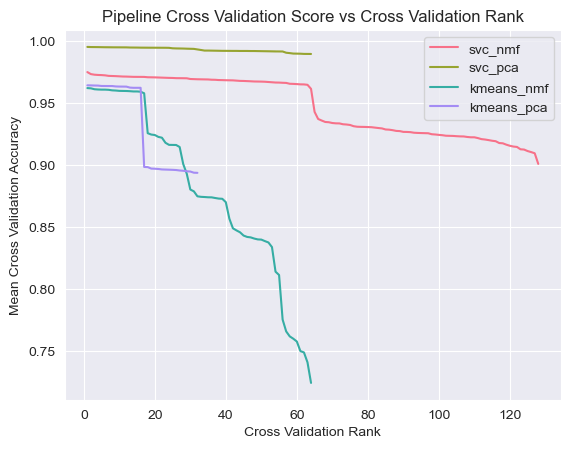

In [141]:
fig, ax = plt.subplots()
sns.lineplot(data=cv_results['svc']['nmf'], x = 'rank_test_score', y = 'mean_test_score', ax = ax, label = 'svc_nmf')
sns.lineplot(data=cv_results['svc']['pca'], x = 'rank_test_score', y = 'mean_test_score', ax = ax, label = 'svc_pca')
sns.lineplot(data=cv_results['kmeans']['nmf'], x = 'rank_test_score', y = 'mean_test_score', ax = ax, label = 'kmeans_nmf')
sns.lineplot(data=cv_results['kmeans']['pca'], x = 'rank_test_score', y = 'mean_test_score', ax = ax, label = 'kmeans_pca')
ax.set_title('Pipeline Cross Validation Score vs Cross Validation Rank')
ax.set_xlabel('Cross Validation Rank')
ax.set_ylabel('Mean Cross Validation Accuracy')

In [121]:
test_scores = {}
train_scores = {}
test_scores['svc_nmf'] = best_estimators['svc']['nmf'].score(X_test, y_test)
test_scores['svc_pca'] = best_estimators['svc']['pca'].score(X_test, y_test)
test_scores['kmeans_nmf'] = best_estimators['kmeans']['nmf'].score(X_test, y_test)
test_scores['kmeans_pca'] = best_estimators['kmeans']['pca'].score(X_test, y_test)

train_scores['svc_nmf'] = best_estimators['svc']['nmf'].score(X_train, y_train)
train_scores['svc_pca'] = best_estimators['svc']['pca'].score(X_train, y_train)
train_scores['kmeans_nmf'] = best_estimators['kmeans']['nmf'].score(X_train, y_train)
train_scores['kmeans_pca'] = best_estimators['kmeans']['pca'].score(X_train, y_train)

Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


(0.94, 1.0)

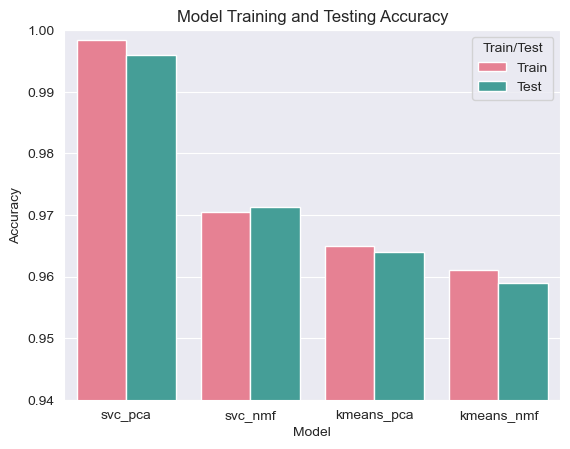

In [140]:
train_df = pd.DataFrame(train_scores, index = ['Train'])
test_df = pd.DataFrame(test_scores, index = ['Test'])

scores_df =(pd.concat([train_df, test_df], axis = 0).
                                        reset_index(names='Train/Test').
                                        melt(id_vars='Train/Test',
                                            var_name = 'Model',
                                            value_name = 'Accuracy'))
sns.barplot(scores_df.
                sort_values('Accuracy', ascending = False),
            x = 'Model',
            y = 'Accuracy',
            hue = 'Train/Test',
            palette = 'husl')
plt.title('Model Training and Testing Accuracy')
plt.ylim(.94,1)

In [169]:
scores_df

,Train/Test,Model,Accuracy
0,Train,svc_nmf,0.970505
1,Test,svc_nmf,0.971346
2,Train,svc_pca,0.998423
3,Test,svc_pca,0.996004
4,Train,kmeans_nmf,0.960988
5,Test,kmeans_nmf,0.958885
6,Train,kmeans_pca,0.964932
7,Test,kmeans_pca,0.963933


Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Predicting...


C:\Users\theru\scoop\apps\anaconda3\current\App\envs\DS\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Text(0.5, 1.0, 'KMeans with NMF')

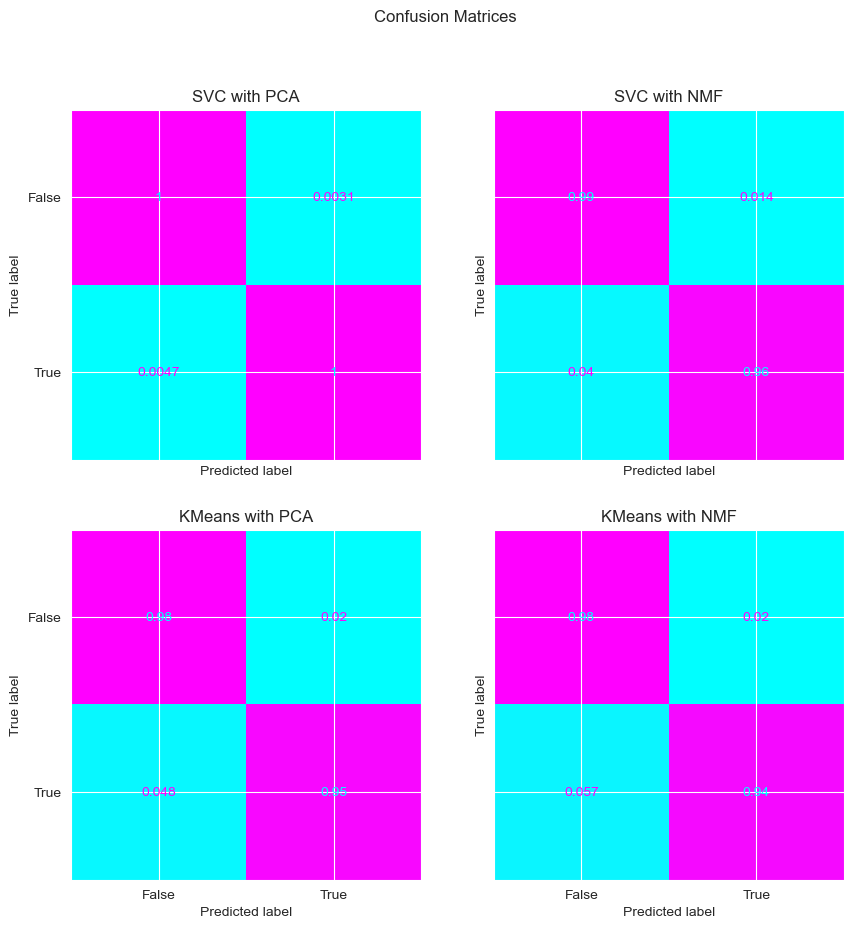

In [136]:
cmd = ConfusionMatrixDisplay
fig, ax = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = True, dpi = 100)
cmd.from_predictions(best_estimators['svc']['pca'].predict(X_test), y_test, ax = ax[0][0], normalize = 'true', cmap = 'cool', colorbar = False)
cmd.from_predictions(best_estimators['svc']['nmf'].predict(X_test), y_test, ax = ax[0][1], normalize = 'true', cmap = 'cool', colorbar = False)
cmd.from_predictions(best_estimators['kmeans']['pca'].predict(X_test), y_test, ax = ax[1][0], normalize = 'true', cmap = 'cool', colorbar = False)
cmd.from_predictions(best_estimators['kmeans']['nmf'].predict(X_test), y_test, ax = ax[1][1], normalize = 'true', cmap = 'cool', colorbar = False)
#ax[0][0].axis('off')
fig.suptitle('Confusion Matrices')
ax[0][0].set_title('SVC with PCA')
ax[0][1].set_title('SVC with NMF')
ax[1][0].set_title('KMeans with PCA')
ax[1][1].set_title('KMeans with NMF')
#ax[0][1].axis('off')
#ax[1][0].axis('off')
#ax[1][1].axis('off')

# Results Summary

The Support Vector Classifier(SVC) using Non-Negative Matrix Factorization(NMF) preprocessing achieved a training accuracy of 97.1% and a test accuracy of 97.1%. The SVC using Principal Component Analysis(PCA) preprocessing achieved a training accuracy of 99.8% and a test accuracy of 99.6%. The K-Means Clustering model using NMF preprocessing achieved a training accuracy of 96.1% and a test accuracy of 96.1%. The K-Means clustering model using PCA preprocessing achieved a training accuracy of 96.5% and a test accuracy of 96.4%. The model with the best test accuracy was the SVC with PCA, achieving a test accuracy of 99.6%. The trained pipelines have been pickled and are available in the models folder of this project.

In [170]:
scores_df

,Train/Test,Model,Accuracy
0,Train,svc_nmf,0.970505
1,Test,svc_nmf,0.971346
2,Train,svc_pca,0.998423
3,Test,svc_pca,0.996004
4,Train,kmeans_nmf,0.960988
5,Test,kmeans_nmf,0.958885
6,Train,kmeans_pca,0.964932
7,Test,kmeans_pca,0.963933


# Discussion

While both classes of model performed very well on this task the SVCs had an error rate 10x lower than that achieved by K-Means (.5% vs 5%). This is not particularly suprising because support vector machines excel at partitioning high dimension spaces such as the sparse matrices generated by Tf-Idf. K-Means on the other hand suffers heavily from the curse of dimensionality since distance metrics tend to converge as the number of features becomes very large. The inclusion of Principal Component Analysis and Non-Negative Matrix Factorization to reduce the dimensionality of the document vectors was crucial. When using NMF preprocessing, cross validation chose 8 components to apply K-means to compared to 40 chosen for SVC. 

While the models performed very well on the chosen data set, it is unclear how well they will generalize to articles not present in the training data or if they would be useful for flagging posts on social media. In order for a method to be useful on a social media platform, it must be able to not only discriminate between real and fake news but disinformation, misinformation and satire as well. It might be desirable for a social media platform to tag posts that are potentially misinformation so that readers are aware and remove posts that are disinformation or malinformative. Additionally, satire posts might need to be handled under a separate condition. 

# Conclusion

Four pipelines were trained to perform binary document classification on ~40,000 articles from the ISOT Fake News Dataset. The data was cleaned to remove duplicates and stubs. The data was split into training and validation sets of equal size (~20,000). Term-Frequency Inverse-Document-Frequency was used to vectorize the titles and bodies of the articles. Dimensionality reduction was then applied using
Principal Component Analysis or Non-Negative Matrix Factorization. Finally, predictions were made using a Support Vector Classifier or with
K-Means(K=2) Clustering. The 4 pipelines were tuned using Grid Search Cross Validation. Cross Validation accuracy was used to select the best parameters. Validation set accuracy was used to select the best model.
The PCA-SVC pipeline achieved a test set accuracy of 99.6%. The NMF-SVC pipeline achieved a test set accuracy of 97.1%. The PCA-KMeans pipeline achieved a
test set accuracy of 96.4%. The NMF-KMeans pipeline achieved a test set accuracy of 96.1%. The best overall pipeline was the PCA-SVC pipeline with an accuracy of 99.6%

# References

1. [The Misinformation Paradox: Understanding Its Propagation and Impact](https://disa.org/the-misinformation-paradox-understanding-its-propagation-and-impact/)
2. [Fake News/Misinformation/Disinformation : What is Confirmation Bias?](https://subjectguides.lib.neu.edu/fakenews/bias)
3. [Fake news detection algorithms – A systematic literature review](https://www.sciencedirect.com/science/article/abs/pii/S0169023X25000369)
4. [Presenting a bi-classification model to detect fake news from textual data using artificial intelligence methods and text analysis techniques](https://journals.sagepub.com/doi/full/10.1177/18724981251319628)
5. [Fake News Detection Using Supervised Binary Classification Techniques](https://ieeexplore.ieee.org/document/10563545)
6. [Word embedding and classification methods and their effects on fake news detection](https://www.sciencedirect.com/science/article/pii/S2666827024000422#sec2)
7. [Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques](https://link.springer.com/chapter/10.1007/978-3-319-69155-8_9)